In [292]:
# import all modules here
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate import simpson
from scipy.special import jv # bessel function of the first kind
import seaborn as sns
sns.set()
sns.set_style("white")

%load_ext autoreload
%autoreload 2
import floquet as fl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
import bite_surface as bs

In [294]:
ks_surf,es_surf=bs.spectrum_3DTI_surface(ky=0,A1=2.26,B1=6.86,A2=3.33,B2=44.5,C=0,D1=5.74,D2=30.4,M=-0.50,R1=50.6*0,R2=-113.3*0)


(-0.1, 0.1)

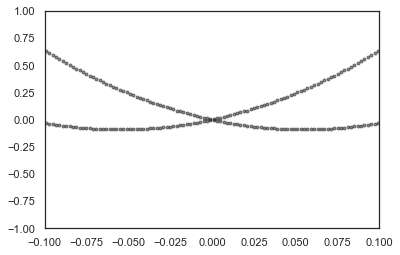

In [99]:
plt.scatter(ks_surf,es_surf,c='k',marker='.',alpha=0.5)
plt.ylim(-1,1)
plt.xlim(-0.1,0.1)

In [309]:
# define all variables
s0 = np.array([[1,0],[0,1]])
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

# hbar is a global variable
hbar = 0.6582119569 # ev * fs

# these are parameters
v = 3.6/hbar # Ang/fs
Omega = 0.12/hbar # fs^-1
Tpump = 106.16 # fs
Tprobe = 26 # fs
eE0 = 7.5e-3 # eV / Ang
mu = 0.3 # eV
wf = mu/hbar # fs^-1

In [310]:
A2 = 3.33
D2 = 30.4

In [353]:
def spectrum():
    res = 1000
    s = 2
    ks = np.linspace(-0.1, 0.1, res)
    Es = np.zeros(s*res)

    for i in range(res):
        k = ks[i]
        H = Hbite(k,0,0)
        E, W = np.linalg.eigh(H)
        Es[i*s:(i+1)*s] = E

    ks_ret = np.repeat(ks, s)

    return ks_ret, Es

In [354]:
ks,es=spectrum()

(-1.0, 1.0)

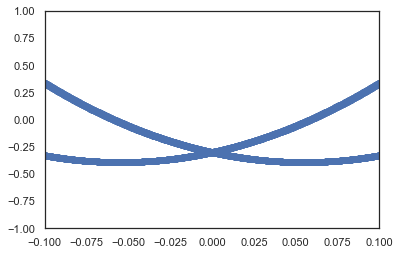

In [355]:
plt.scatter(ks,es)
plt.xlim(-0.1,0.1)
plt.ylim(-1,1)

In [344]:
# function that diagonalizes Ephi=H0phi for IC of Dirac ODE
def Hbite(kx,ky,v):
    H = 3.33*ky*s1 - 3.33*kx*s2 + 30.4*(kx**2+ky**2)*s0 - 0.3*s0
#     kp = kx + 1j*ky
#     km = kx - 1j*ky
#     H = (hbar*3.6+100*(kx**2+ky**2))*(kx*s2 - ky*s1) + 25*(kp**3+km**3)*s3 - 0.3*s0
#     H = (3.6+0*(kx**2+ky**2))*(kx*s2 - ky*s1) + 0*(kp**3+km**3)*s3 - 0.3*s0    
    return H

def InitialConditions(kx,ky,v):
    """
    Returns phi and E for the time-independent Hamiltonian
    phi[:,alpha] is the alpha'th eigenvector
    """
    # initial Hamiltonian
    hk = Hbite(kx,ky,v)
    
    # diagonalize it
    E, phi = np.linalg.eigh(hk)
    
    return E, phi

In [345]:
# function f in dt{psi} = f(t,psi)
def dirac(t,psi,kx,ky,v,eE0,Omega,Tpump):
    # add peierls momentum
    kx_bump = -eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.cos(Omega*t) / hbar # important to divide by hbar since sub is hbar*k -> eA
    ky_bump = eE0/Omega * np.exp(-t**2/(2*Tpump**2)) * np.sin(Omega*t) / hbar
    # get H
    H = Hbite(kx+kx_bump,ky+ky_bump,v)
    # return schrodinger
    f = -1j/hbar * H @ psi
    return f

In [346]:
# enveloppe and fermi functions. 
# the latter is functionally irrelevant as we consider low T
def Enveloppe(t,t0,Tprobe):
    """
    Probe pulse enveloppe function
    """
    return np.exp(-(t-t0)**2/(2*Tprobe**2))

def Fermi(E,kT):
    """
    Fermi distribution
    """
    if kT==0:
        return np.heaviside(-E,0.5)
    else:
        f = 1/(np.exp(E/kT) + 1)
    return f

In [356]:
# workhorses

# integrates s(t,t0)*e^{iwt}*psi_{alpha,s}(t) and modulus squared
# this is the heart of the program
def PhotocurrentSA(psi,s,kx,ky,w,t0,v,eE0,Omega,Tpump,Tprobe):
    # t-space
    t_space = psi.t
    # integrand: enveloppe * phase * psi
    integrand = Enveloppe(t_space,t0,Tprobe) * np.exp(1j*w*t_space) * psi.y[s,:]
    # integrate samples data using simpson's rule
    I = simpson(integrand,x=t_space)
    return np.abs(I)**2

# main function
def Photocurrent(psi_plus,psi_minus,kx,ky,Es,w,t0,v,eE0,Omega,Tpump,Tprobe):
    """
    Main photocurrent function
    Es[i] corresponds to the energy of the minus (i=0) or plus (i=1) psi
    """
    # the phis are solved for in the main looping function (30/01/23 change)
    
    # integrate and add it up
    P = 0
    for s in range(2):
        # add up both spins
        P += Fermi(Es[0],kT=0) * PhotocurrentSA(psi_minus,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe) 
        P += Fermi(Es[1],kT=0) * PhotocurrentSA(psi_plus,s=s,kx=kx,ky=ky,w=w,t0=t0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
    return P

# function to help plotting and making arrays to visualize
def PhotocurrentArrayEnergy(res_w,kx,ky,t0,v,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in w 
    """
    # set initial parameters
    ws = np.linspace(-1,1,res_w) - 0.3 #np.linspace(-np.pi,np.pi,res_w)*Omega - mu/hbar # from inverting (w-wF)/Omega
    
    # diagonalize the time-independent system (at t-> -\infty)
    Es, phis = InitialConditions(kx,ky,v)

    # solve the dirac equation
    psi_plus = solve_ivp(fun=dirac, t_span=[-2000,1000], y0=phis[:,1], args=(kx,ky,v,eE0,Omega,Tpump), method='RK45')
    psi_minus = solve_ivp(fun=dirac, t_span=[-2000,1000], y0=phis[:,0], args=(kx,ky,v,eE0,Omega,Tpump), method='RK45')

    P = np.zeros(res_w, dtype=float)
    for i,w in enumerate(ws):
        P[i] = Photocurrent(psi_plus=psi_plus,psi_minus=psi_minus,Es=Es,kx=kx,ky=ky,w=w,t0=t0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
            
    return ws, P

In [361]:
ws5, Ps5 = PhotocurrentArrayEnergy(res_w=300,kx=0.0,ky=0,t0=-500,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws1, Ps1 = PhotocurrentArrayEnergy(res_w=300,kx=0.0,ky=0,t0=-100,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)
ws0, Ps0 = PhotocurrentArrayEnergy(res_w=300,kx=0.0,ky=0,t0=0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)

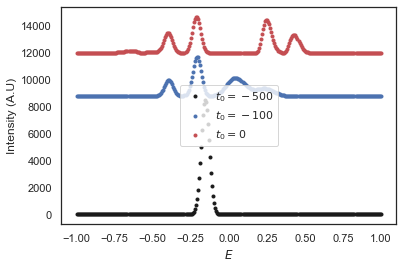

In [362]:
# plot it
plt.figure()

plt.scatter(ws5+0.3,Ps5,c='k',marker='.',label=r"$t_0 = -500$")

shift1 = np.max(Ps5) + 250

plt.scatter(ws1+0.3,Ps1+shift1,c='b',marker='.',label=r"$t_0 = -100$")

shift2 = shift1 + np.max(Ps1) + 250

plt.scatter(ws0+0.3,Ps0+shift2,c='r',marker='.',label=r"$t_0 = 0$")
plt.legend()
# plt.xlabel(r"$\left(\omega+\omega_F\right)/\Omega$")
plt.xlabel(r"$E$")
plt.ylabel(r"Intensity (A.U)")
plt.show()

In [363]:
def PhotocurrentArrayWK(k_dir,k_other,t0,v,eE0,Omega,Tpump,Tprobe):
    """
    Makes an array in k-w plane 
    k_dir==1 for x and 2 for y
    k_other is the value of the remaining momentum
    """
    # set initial parameters
    res = 100
    res_k = res
    res_w = res
    
    # make arrays
    ks = np.linspace(-0.1,0.1,res_k)
    P = np.zeros((res_k,res_w), dtype=float)
    
    # loop over k
    if k_dir == 1:
        for i,kx in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,kx=kx,ky=k_other,t0=t0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
            
    elif k_dir == 2:
        for i,ky in enumerate(ks):
            P[i,:] = PhotocurrentArrayEnergy(res_w=res_w,kx=k_other,ky=ky,t0=t0,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)[1] # second component is ps
        
    return P

In [364]:
P = PhotocurrentArrayWK(k_dir=1,k_other=0,t0=-500,v=v,eE0=eE0,Omega=Omega,Tpump=Tpump,Tprobe=Tprobe)


In [ ]:
plt.imshow(P.T)
# plt.xticks([coord_to_res(0,0.1,-0.1,100)])
plt.ylim(0,99)
plt.show()